# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.699408,True,9.189256
1,1.709454,False,3.605616
2,3.282476,True,12.706027
3,-1.935062,False,-4.208031
4,-0.044965,False,-0.700791
...,...,...,...
995,-0.349081,False,-2.647624
996,2.591046,True,12.995542
997,0.095390,False,1.869155
998,1.048704,True,7.979649


<AxesSubplot: xlabel='v0'>

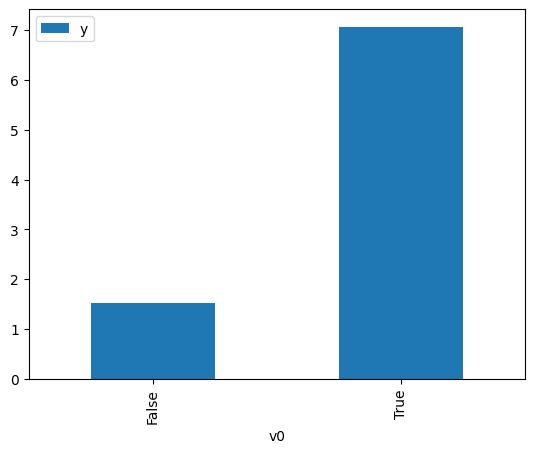

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

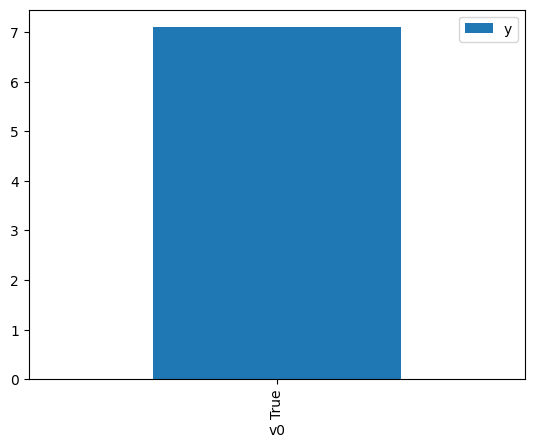

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.279028,False,2.313435,0.123623,8.089133
1,0.015746,False,2.764644,0.514830,1.942388
2,0.454872,False,2.580646,0.344772,2.900465
3,-0.334767,False,-0.489637,0.650043,1.538359
4,0.278230,False,-0.121157,0.410974,2.433244
...,...,...,...,...,...
995,-0.432144,False,-0.232987,0.684553,1.460808
996,1.555486,False,4.289671,0.083160,12.024974
997,-1.108604,False,-2.770635,0.864750,1.156403
998,1.352445,False,2.159773,0.111468,8.971203


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.796326,True,10.609176,0.941853,1.061737
1,0.478663,True,6.353521,0.663761,1.506565
2,2.248043,True,11.943103,0.970870,1.030004
3,0.568551,True,7.861082,0.695018,1.438812
4,1.345824,True,7.107811,0.887480,1.126785
...,...,...,...,...,...
995,-0.817819,True,0.975855,0.199275,5.018190
996,0.356804,True,4.735507,0.619034,1.615420
997,0.912909,True,8.377771,0.797984,1.253158
998,0.215876,True,5.632446,0.564720,1.770790


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          2.497e+04
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:29:37   Log-Likelihood:                         -1439.1
No. Observations:                1000   AIC:                                      2882.
Df Residuals:                     998   BIC:                                      2892.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5924      0.037     70.372      0.000       2.520       2.665
x2             4.9572      0.059     83.655      0.000       4.841       5.073
==============================================================================
Omnibus:                        8.903   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                6.817
Skew:                          -0.097   Prob(JB):                       0.0331
Kurtosis:                       2.645   Cond. No.                         3.13
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""